### Загружаем библиотеки

In [528]:
import numpy as np #алгебраические вычисления
import pandas as pd #работа с массивами данных

import matplotlib #графическое отображение данных
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import datetime #для расчета скорости выполнения программы

### Функция для расчета метрик и построения графиков

In [529]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Функция оптимизация памяти

In [530]:
def reduce_mem_usage(df):
    
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### Загрузка данных

In [531]:
# указываем путь к скачаным файлам
Train_DATA_dir = 'real-estate-price-prediction-moscow/train.csv'
Test_DATA_dir = 'real-estate-price-prediction-moscow/test.csv'
train_df = pd.read_csv(Train_DATA_dir)
test_df = pd.read_csv(Test_DATA_dir)

Запускаем __train_df__ и изучаем содержимое:

In [532]:
start = datetime.datetime.now() #расчет времени выполнения

In [533]:
train_df.info()
# видим пропуски в двух колонках: 'LifeSquare' & 'Healthcare_1'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [534]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


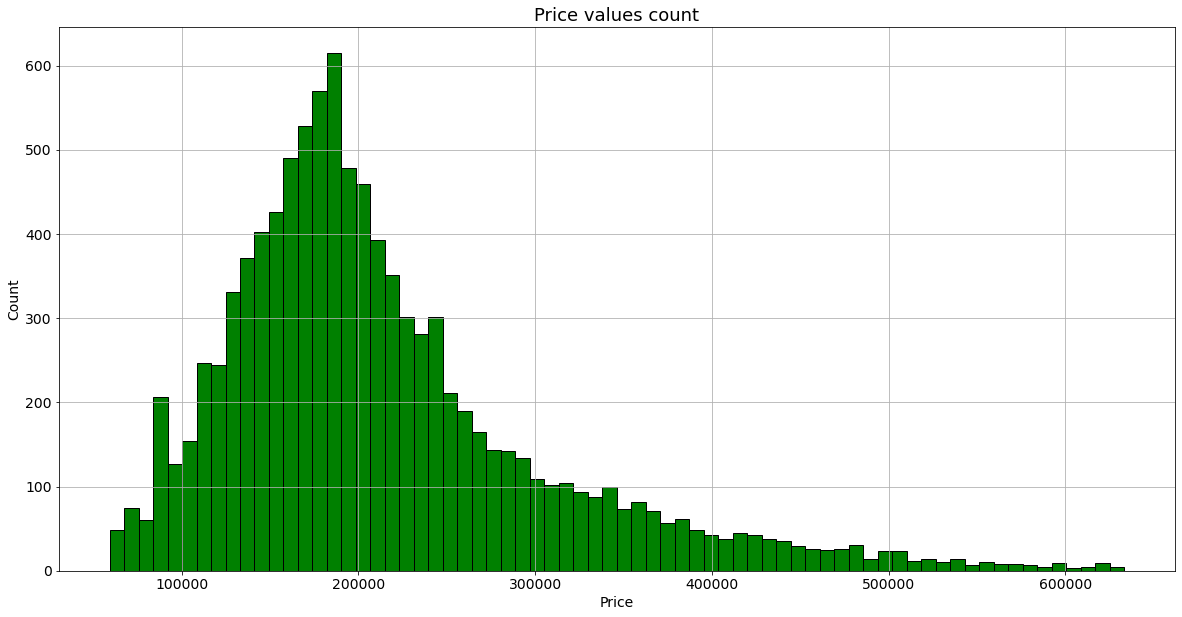

count     10000.000000
mean     214138.857399
std       92872.293865
min       59174.778028
25%      153872.633942
50%      192269.644879
75%      249135.462171
max      633233.466570
Name: Price, dtype: float64

In [535]:
# целевая переменная

plt.figure(figsize=(20,10))
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Price values count', fontsize=18)
train_df['Price'].hist(bins = 70, edgecolor = 'black', color = 'green')
plt.show()
train_df['Price'].describe()

### Обработка датафрейма

###### 1. Данные о площади квартир

In [536]:
#знакомлюсь с параметрами 
train_df['Square'].describe(), \
train_df['LifeSquare'].describe(), \
train_df['KitchenSquare'].describe()

(count    10000.000000
 mean        56.315775
 std         21.058732
 min          1.136859
 25%         41.774881
 50%         52.513310
 75%         65.900625
 max        641.065193
 Name: Square, dtype: float64,
 count    7887.000000
 mean       37.199645
 std        86.241209
 min         0.370619
 25%        22.769832
 50%        32.781260
 75%        45.128803
 max      7480.592129
 Name: LifeSquare, dtype: float64,
 count    10000.000000
 mean         6.273300
 std         28.560917
 min          0.000000
 25%          1.000000
 50%          6.000000
 75%          9.000000
 max       2014.000000
 Name: KitchenSquare, dtype: float64)

In [537]:
#избавляемся от выбросов в значениях площади кухни через квантили
train_df['KitchenSquare'].value_counts(normalize=True)

1.0       0.2460
8.0       0.1306
5.0       0.1169
10.0      0.1075
6.0       0.1038
9.0       0.0843
0.0       0.0697
7.0       0.0609
12.0      0.0249
11.0      0.0233
13.0      0.0067
14.0      0.0051
4.0       0.0039
15.0      0.0031
3.0       0.0022
16.0      0.0016
20.0      0.0014
17.0      0.0012
19.0      0.0011
18.0      0.0006
2.0       0.0004
22.0      0.0003
30.0      0.0002
43.0      0.0002
41.0      0.0002
112.0     0.0002
25.0      0.0002
51.0      0.0002
37.0      0.0002
58.0      0.0002
32.0      0.0002
21.0      0.0001
73.0      0.0001
75.0      0.0001
36.0      0.0001
27.0      0.0001
63.0      0.0001
1970.0    0.0001
54.0      0.0001
53.0      0.0001
60.0      0.0001
26.0      0.0001
66.0      0.0001
39.0      0.0001
29.0      0.0001
78.0      0.0001
31.0      0.0001
84.0      0.0001
48.0      0.0001
96.0      0.0001
42.0      0.0001
40.0      0.0001
23.0      0.0001
72.0      0.0001
35.0      0.0001
62.0      0.0001
123.0     0.0001
2014.0    0.0001
Name: KitchenS

In [538]:
train_df['KitchenSquare'].quantile(.99), train_df['KitchenSquare'].quantile(.01)

(16.0, 0.0)

In [539]:
#Все, что больше 16 заменяем на медиану, то, что меньше 3 - приравниваем к 3
train_df.loc[(train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.99), 'KitchenSquare')] = \
              train_df['KitchenSquare'].median()
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
train_df['KitchenSquare'].value_counts()

3.0     3183
8.0     1306
5.0     1169
6.0     1129
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
14.0      51
4.0       39
15.0      31
16.0      16
Name: KitchenSquare, dtype: int64

In [540]:
#Заполняем пропуски в 'LifeSquare'
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare']
train_df['LifeSquare'].describe()

count    10000.000000
mean        41.362674
std         77.727053
min          0.370619
25%         25.451477
50%         36.553619
75%         49.383435
max       7480.592129
Name: LifeSquare, dtype: float64

In [541]:
#Смотрим, есть ли строки, в которых значения колонки LifeSquare больше колонки Square
train_df.query('LifeSquare > Square').describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,482.000000,169.000000,482.000000,482.000000,482.000000
mean,8267.912863,32.902490,1.773859,58.730783,77.562913,4.562241,9.844398,13.699170,1999.740664,0.103546,14.804979,3405.558091,9.273859,866.757396,0.865145,3.502075,199994.080652
std,4920.619796,28.090306,0.810983,29.209970,339.778223,2.858635,6.236391,9.918523,19.726434,0.111658,16.443418,3779.515558,30.818422,643.457287,1.395146,5.441524,98679.855973
min,10.000000,1.000000,1.000000,1.136859,2.642219,3.000000,1.000000,0.000000,1958.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,66630.740772
25%,3917.000000,8.250000,1.000000,40.818859,42.247472,3.000000,4.000000,6.000000,1977.000000,0.011654,2.000000,629.000000,0.000000,540.000000,0.000000,0.000000,133584.977352
50%,8180.500000,27.000000,2.000000,53.797480,56.007028,3.000000,9.000000,17.000000,2015.000000,0.072158,6.000000,1564.000000,1.000000,705.000000,0.000000,1.000000,177867.263469
75%,12375.000000,48.000000,2.000000,70.938033,73.066011,5.000000,14.000000,17.000000,2017.000000,0.195781,24.000000,5735.000000,3.000000,1046.000000,1.750000,5.000000,233790.539544
max,16781.000000,187.000000,4.000000,409.425181,7480.592129,15.000000,28.000000,117.000000,2020.000000,0.486246,74.000000,19083.000000,141.000000,3855.000000,6.000000,23.000000,621002.912679


In [542]:
# Предполагаю что ошибка допущена при вводе данных. Поменяю местами значения соответствующих ячеек Square и LifeSquare.  
df_tmp = train_df[['Square','LifeSquare']]
train_df['Square'], train_df['LifeSquare'] = df_tmp.max(axis=1), df_tmp.min(axis=1)
(train_df['LifeSquare'] > train_df['Square']).sum()

0

Избавляемся от выбросов в Square и LifeSquare через квантили

In [543]:
train_df['Square'].quantile(.9995), train_df['Square'].quantile(.0005)

(275.7127813084318, 4.633490930077289)

In [544]:
train_df.loc[(train_df['Square'] > train_df['Square'].quantile(.9995), 'Square')] = train_df['Square'].median()
train_df.loc[train_df['Square'] < 20, 'Square'] = 20
train_df['Square'].sort_values().unique()

array([ 20.        ,  20.03623233,  20.21312772, ..., 212.93236105,
       263.54202007, 275.64528408])

In [545]:
train_df['LifeSquare'].quantile(.9995), train_df['LifeSquare'].quantile(.0005)

(200.33998768343804, 1.0711820242425403)

In [546]:
train_df.loc[(train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.9995), 'LifeSquare')] = train_df['LifeSquare'].median()
train_df.loc[train_df['LifeSquare'] < 15, 'LifeSquare'] = 15
train_df['LifeSquare'].sort_values().unique()

array([ 15.        ,  15.00123434,  15.11607987, ..., 169.50994065,
       174.64952176, 200.33453939])

In [547]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.305858,40.511715,6.322900,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,19.246108,19.402308,2.915559,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,20.000000,15.000000,3.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.866858,25.432443,3.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.628427,36.518728,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.983195,49.195454,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,275.645284,200.334539,16.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [548]:
# еще раз проверяем, если ли случаи превышения значения LifeSquare над Square и KitchenSquare над LifeSquare. 
# При необходимости меняем значения местами
(train_df['LifeSquare'] > train_df['Square']).sum()
df_tmp = train_df[['Square','LifeSquare']]
train_df['Square'], train_df['LifeSquare'] = df_tmp.max(axis=1), df_tmp.min(axis=1)
(train_df['LifeSquare'] > train_df['Square']).sum()

0

In [549]:
(train_df['KitchenSquare'] > train_df['LifeSquare']).sum()

0

###### 2.Количество комнат

In [550]:
train_df['Rooms'].value_counts(normalize=True)
# исходя из доли исследуемых квартир с количеством комнат 0, 6, 10 и 19, можно принять указанные значения за выбросы 

2.0     0.3880
1.0     0.3705
3.0     0.2235
4.0     0.0150
5.0     0.0018
0.0     0.0008
10.0    0.0002
19.0    0.0001
6.0     0.0001
Name: Rooms, dtype: float64

In [551]:
train_df.query('Rooms == (0, 6, 10, 19)') 
# смотрю параметры прощади квартир со значением комнат "0", "6", "10", "19".  
# В результате пришел к выводу, что это выбросы

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2004,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
2728,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863
3780,7317,27,0.0,41.790881,38.790881,3.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
5894,770,28,0.0,49.483501,46.483501,3.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
6088,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
6401,9443,27,0.0,87.762616,85.125471,3.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007
7644,7917,27,0.0,212.932361,36.521647,3.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
7929,456,6,0.0,81.491446,78.491446,3.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
8794,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416


In [552]:
#меняю значения выбросов на медиану 
train_df.loc[train_df['Rooms'].isin([0, 6, 10, 19]), 'Rooms'] = train_df['Rooms'].median()
train_df['Rooms'].value_counts()

2.0    3892
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

###### 3.Этажность

In [553]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [554]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [555]:
train_df.query('HouseFloor == (99, 117)') 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
746,9300,74,2.0,74.579809,71.747869,9.0,5,99.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,243329.912579
1678,78,30,2.0,66.811789,65.773749,3.0,8,117.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,207248.370520
4657,10806,5,1.0,51.944587,48.709601,3.0,6,99.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,296127.115515


In [556]:
#меняю значения этажности дома "0, 99, 117" на медиану
train_df.loc[train_df['HouseFloor'].isin([0, 99, 117]), 'HouseFloor'] = train_df['HouseFloor'].median()

In [557]:
#смотрю, есть ли случаи, когда этаж квартиры больше этажности дома и меняю такие значения местами
train_df.query('Floor > HouseFloor').describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,1610.000000,827.000000,1610.000000,1610.000000,1610.000000
mean,8416.131056,49.001242,1.900000,58.419776,44.128273,5.267702,11.226708,7.447205,1984.011180,0.114228,22.722981,4952.216770,9.644720,1104.559855,1.309938,4.268944,214394.675359
std,4942.331362,41.130921,0.821896,21.726877,22.949150,2.731582,5.821258,6.226410,19.702697,0.113476,16.833969,3800.545396,28.070527,990.903867,1.500847,5.202461,96021.643259
min,33.000000,0.000000,1.000000,20.000000,15.000000,3.000000,2.000000,1.000000,1914.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,60918.567890
25%,3938.500000,23.000000,1.000000,42.789076,27.380078,3.000000,6.000000,1.000000,1973.000000,0.019509,5.000000,1564.000000,0.000000,350.000000,0.000000,0.000000,151414.823625
50%,8422.500000,34.000000,2.000000,54.648494,39.725571,5.000000,10.000000,5.000000,1977.000000,0.072158,23.000000,5212.000000,2.000000,990.000000,1.000000,3.000000,190256.215966
75%,12817.250000,70.750000,2.000000,68.037187,56.071408,7.000000,16.000000,12.000000,2002.000000,0.194489,34.000000,6565.500000,5.000000,1450.000000,3.000000,6.000000,245170.402422
max,16785.000000,209.000000,5.000000,263.542020,167.379494,16.000000,28.000000,25.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,627525.072788


In [558]:
df_tmp = train_df[['Floor','HouseFloor']]
train_df['HouseFloor'], train_df['Floor'] = df_tmp.max(axis=1), df_tmp.min(axis=1)
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

###### 4.Год постройки дома

In [559]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [560]:
# смотрю, сколько значений года постройки дома '4968' и '20052011'
# заменю их соответственно на 1968(ошибка в первой цифре) и 2008(среднее между 2005 и 2011)
train_df['HouseYear'].isin([4968, 20052011]).value_counts()

False    9998
True        2
Name: HouseYear, dtype: int64

In [561]:
train_df.loc[train_df['HouseYear'].isin([4968]), 'HouseYear'] = 1968
train_df.loc[train_df['HouseYear'].isin([20052011]), 'HouseYear'] = 2011
train_df['HouseYear'].isin([4968, 20052011]).value_counts()

False    10000
Name: HouseYear, dtype: int64

###### 5.Пропуски в Healthcare_1

In [562]:
#Сложно понять от чего зависит параметр, не зная критериев его вывода, поэтому заменяю пропуски на медиану
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()
(train_df['Healthcare_1'].isnull()).sum()

0

###### 6.Бинарные показатели

In [563]:
#Переводим показатели Ecology_2, Ecology_3, Shops_2 в бинарные
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,105.027311,10.0,4.0,10.0,2014,0.075424,B,B,11,3097,0,900.0,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,37.409907,3.0,10.0,22.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,B,B,33,8667,2,900.0,0,6,B,343995.102962
5,5804,99,3.0,62.528465,47.103833,6.0,9.0,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138
6,8864,44,1.0,33.938750,21.772930,9.0,1.0,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.739272
7,13072,59,2.0,50.391814,32.893256,8.0,8.0,17.0,1986,0.019509,B,B,37,7687,11,176.0,5,5,B,326174.175191
8,9951,1,1.0,46.887892,44.628132,3.0,12.0,20.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,160400.401732
9,8094,6,3.0,79.867477,75.085125,3.0,3.0,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.023945


In [564]:
bin_param = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(bin_param)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(bin_param)
train_df['Shops_2'] = train_df['Shops_2'].replace(bin_param)

In [565]:
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,105.027311,10.0,4.0,10.0,2014,0.075424,1,1,11,3097,0,900.0,0,0,1,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,1,1,30,6207,1,1183.0,1,0,1,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,1,1,33,5261,0,240.0,3,1,1,282078.720850
3,2352,1,1.0,40.409907,37.409907,3.0,10.0,22.0,1977,0.007122,1,1,1,264,0,900.0,0,1,1,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,1,1,33,8667,2,900.0,0,6,1,343995.102962
5,5804,99,3.0,62.528465,47.103833,6.0,9.0,9.0,1972,0.012339,1,1,35,5776,1,2078.0,2,4,1,161044.944138
6,8864,44,1.0,33.938750,21.772930,9.0,1.0,12.0,1968,0.232205,1,1,24,4860,1,80.0,0,3,1,142402.739272
7,13072,59,2.0,50.391814,32.893256,8.0,8.0,17.0,1986,0.019509,1,1,37,7687,11,176.0,5,5,1,326174.175191
8,9951,1,1.0,46.887892,44.628132,3.0,12.0,20.0,1977,0.007122,1,1,1,264,0,900.0,0,1,1,160400.401732
9,8094,6,3.0,79.867477,75.085125,3.0,3.0,17.0,2014,0.243205,1,1,5,1564,0,540.0,0,0,1,194756.023945


###### 7.Новые параметры

#### 7.1 Количество предложений по продаже в районе

In [566]:
train_df['DistrictId'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [567]:
flats_in_distr = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'flats_in_distr'})
flats_in_distr.head()

,DistrictId,flats_in_distr
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [568]:
train_df = train_df.merge(flats_in_distr, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,flats_in_distr
0,11809,27,3.0,115.027311,105.027311,10.0,4.0,10.0,2014,0.075424,...,1,11,3097,0,900.0,0,0,1,305018.871089,851
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,1,30,6207,1,1183.0,1,0,1,177734.553407,78
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,1,33,5261,0,240.0,3,1,1,282078.720850,652
3,2352,1,1.0,40.409907,37.409907,3.0,10.0,22.0,1977,0.007122,...,1,1,264,0,900.0,0,1,1,168106.007630,652
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,1,33,8667,2,900.0,0,6,1,343995.102962,89


#### 7.2 Активность продаж в районе

In [569]:
train_df['Sales_activity'] = (train_df['flats_in_distr'] > 100).astype(int)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,flats_in_distr,Sales_activity
0,11809,27,3.0,115.027311,105.027311,10.0,4.0,10.0,2014,0.075424,...,11,3097,0,900.0,0,0,1,305018.871089,851,1
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,30,6207,1,1183.0,1,0,1,177734.553407,78,0
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,33,5261,0,240.0,3,1,1,282078.720850,652,1
3,2352,1,1.0,40.409907,37.409907,3.0,10.0,22.0,1977,0.007122,...,1,264,0,900.0,0,1,1,168106.007630,652,1
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,33,8667,2,900.0,0,6,1,343995.102962,89,0


#### 7.3 Средняя цена квартиры в районе

In [570]:
med_price_by_distr = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'Med_price_by_distr'})
med_price_by_distr.head(), med_price_by_distr.shape

(   DistrictId  Rooms  Med_price_by_distr
 0           0    1.0       142799.434052
 1           0    2.0       176210.812334
 2           0    3.0       300610.359425
 3           1    1.0       146735.671740
 4           1    2.0       202666.310126,
 (667, 3))

In [571]:
train_df = train_df.merge(med_price_by_distr, on=['DistrictId', 'Rooms'], how='left')
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,flats_in_distr,Sales_activity,Med_price_by_distr
0,11809,27,3.0,115.027311,105.027311,10.0,4.0,10.0,2014,0.075424,...,3097,0,900.0,0,0,1,305018.871089,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,...,6207,1,1183.0,1,0,1,177734.553407,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,...,5261,0,240.0,3,1,1,282078.720850,652,1,244005.272380
3,2352,1,1.0,40.409907,37.409907,3.0,10.0,22.0,1977,0.007122,...,264,0,900.0,0,1,1,168106.007630,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,...,8667,2,900.0,0,6,1,343995.102962,89,0,201584.441255
5,5804,99,3.0,62.528465,47.103833,6.0,9.0,9.0,1972,0.012339,...,5776,1,2078.0,2,4,1,161044.944138,97,0,223960.229617
6,8864,44,1.0,33.938750,21.772930,9.0,1.0,12.0,1968,0.232205,...,4860,1,80.0,0,3,1,142402.739272,104,1,171145.169069
7,13072,59,2.0,50.391814,32.893256,8.0,8.0,17.0,1986,0.019509,...,7687,11,176.0,5,5,1,326174.175191,67,0,326174.175191
8,9951,1,1.0,46.887892,44.628132,3.0,12.0,20.0,1977,0.007122,...,264,0,900.0,0,1,1,160400.401732,652,1,146735.671740
9,8094,6,3.0,79.867477,75.085125,3.0,3.0,17.0,2014,0.243205,...,1564,0,540.0,0,0,1,194756.023945,511,1,215707.925347


In [572]:
# дополнительно переведем Id в строковый формат, чтобы по нему не обучалась модель
train_df['Id'] = train_df['Id'].astype(str)
train_df['Rooms'] = train_df['Rooms'].astype(int)
train_df['Floor'] = train_df['Floor'].astype(int)
train_df['HouseFloor'] = train_df['HouseFloor'].astype(int)

train_df.dtypes

Id                     object
DistrictId              int64
Rooms                   int32
Square                float64
LifeSquare            float64
KitchenSquare         float64
Floor                   int32
HouseFloor              int32
HouseYear               int64
Ecology_1             float64
Ecology_2               int64
Ecology_3               int64
Social_1                int64
Social_2                int64
Social_3                int64
Healthcare_1          float64
Helthcare_2             int64
Shops_1                 int64
Shops_2                 int64
Price                 float64
flats_in_distr          int64
Sales_activity          int32
Med_price_by_distr    float64
dtype: object

###### 8.Оптимизация памяти

In [573]:
reduce_mem_usage(train_df)

Memory usage of dataframe is 1.68 MB
Memory usage after optimization is: 0.88 MB
Decreased by 47.5%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,flats_in_distr,Sales_activity,Med_price_by_distr
0,11809,27,3,115.027313,105.027313,10.0,4,10,2014,0.075424,...,3097,0,900.0,0,0,1,305018.875000,851,1,213530.781250
1,3013,22,1,39.832523,23.169222,8.0,7,8,1966,0.118537,...,6207,1,1183.0,1,0,1,177734.546875,78,0,146032.828125
2,8215,1,3,78.342216,47.671970,10.0,2,17,1988,0.025609,...,5261,0,240.0,3,1,1,282078.718750,652,1,244005.265625
3,2352,1,1,40.409908,37.409908,3.0,10,22,1977,0.007122,...,264,0,900.0,0,1,1,168106.000000,652,1,146735.671875
4,13866,94,2,64.285065,38.562515,9.0,16,16,1972,0.282798,...,8667,2,900.0,0,6,1,343995.093750,89,0,201584.437500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2,49.090729,33.272625,6.0,3,12,1981,0.300323,...,10311,6,900.0,1,9,1,119367.453125,118,1,232514.859375
9996,16265,27,2,64.307686,37.038422,9.0,13,13,1977,0.072158,...,629,1,900.0,0,0,0,199715.156250,851,1,165700.359375
9997,2795,178,1,29.648056,16.555363,5.0,3,5,1958,0.460556,...,4386,14,900.0,1,5,1,165953.906250,7,0,165953.906250
9998,14561,21,1,32.330292,22.326870,5.0,3,9,1969,0.194489,...,8004,3,125.0,3,5,1,171842.406250,165,1,153921.406250


In [574]:
train_df.dtypes

Id                    category
DistrictId               int16
Rooms                     int8
Square                 float32
LifeSquare             float32
KitchenSquare          float32
Floor                     int8
HouseFloor                int8
HouseYear                int16
Ecology_1              float32
Ecology_2                 int8
Ecology_3                 int8
Social_1                  int8
Social_2                 int16
Social_3                 int16
Healthcare_1           float32
Helthcare_2               int8
Shops_1                   int8
Shops_2                   int8
Price                  float32
flats_in_distr           int16
Sales_activity            int8
Med_price_by_distr     float32
dtype: object

### Отбираем признаки и разбиваем на тренировочные и тестовые 

In [575]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'flats_in_distr',
 'Sales_activity',
 'Med_price_by_distr']

In [576]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['flats_in_distr', 'Sales_activity', 'Med_price_by_distr']

target_name = 'Price'

In [577]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=12)

#### Строим модели и выбираем наиболее подходящюю

1. __Линейная регрессия__ - показал результат хуже, чем RandomForestRegressor

In [578]:
# lr_model = LinearRegression()
# lr_model.fit(X_train, y_train)
             
# y_train_preds = lr_model.predict(X_train)
# y_test_preds = lr_model.predict(X_test)

# evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

# Train R2:	0.702
# Test R2:	0.7

2. __RandomForestRegressor__

Train R2:	0.964
Test R2:	0.755


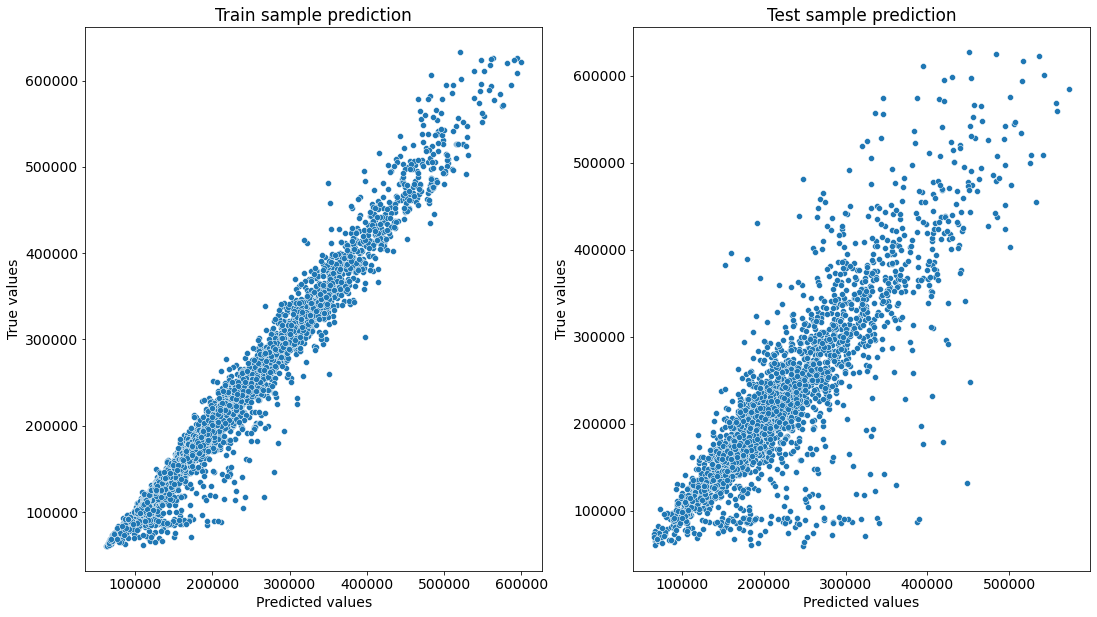

In [579]:
rf_model = RandomForestRegressor(random_state=12)
rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [580]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=4, shuffle=True, random_state=12))
cv_score

array([0.74968253, 0.75174181, 0.76703685, 0.75802416])

In [581]:
cv_score.mean()

0.7566213375669782

3. __Оценка важности признаков__

In [582]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
21,Med_price_by_distr,0.622508
3,Square,0.108390
4,LifeSquare,0.033174
7,HouseFloor,0.026126
8,HouseYear,0.025467
19,flats_in_distr,0.023060
0,Id,0.020704
14,Social_3,0.018499
5,KitchenSquare,0.018228
6,Floor,0.017662


In [583]:
# Попробую построить модель по топ15 признакам и сравню результат:
# Train R2:	0.965
# Test R2:	0.753
# несмотря на незначительное улучшение трейна, на тесте идет снижение. Поэтому оставляю как есть. -->

##### 10.1 Преобразование тестового датасета

In [584]:
test_df.shape

(5000, 19)

In [585]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [586]:
#выбросы площади кухни
test_df.loc[(test_df['KitchenSquare'] > test_df['KitchenSquare'].quantile(.99), 'KitchenSquare')] = \
              test_df['KitchenSquare'].median()
test_df.loc[test_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3
test_df['KitchenSquare'].value_counts()

3.0     1541
6.0      639
5.0      612
8.0      606
10.0     558
9.0      417
7.0      297
12.0     132
11.0     107
13.0      33
4.0       21
14.0      20
15.0      17
Name: KitchenSquare, dtype: int64

In [587]:
#заполняем нули жилой площади
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] = test_df['Square'] - test_df['KitchenSquare']

In [588]:
#замена местами общей площади и площади кухни по условию
df_tmp = test_df[['Square','LifeSquare']]
test_df['Square'], test_df['LifeSquare'] = df_tmp.max(axis=1), df_tmp.min(axis=1)
(test_df['LifeSquare'] > test_df['Square']).sum()

0

In [589]:
#выбросы общей площади
test_df.loc[(test_df['Square'] > test_df['Square'].quantile(.9995), 'Square')] = test_df['Square'].median()
test_df.loc[test_df['Square'] < 20, 'Square'] = 20
test_df['Square'].sort_values().unique()

array([ 20.        ,  20.01121511,  21.45289948, ..., 170.47632584,
       173.97447964, 189.67957638])

In [590]:
#выбросы жилой площади
test_df.loc[(test_df['LifeSquare'] > test_df['LifeSquare'].quantile(.9995), 'LifeSquare')] = test_df['LifeSquare'].median()
test_df.loc[test_df['LifeSquare'] < 15, 'LifeSquare'] = 15
test_df['LifeSquare'].sort_values().unique()

array([ 15.        ,  15.0198066 ,  15.03996128, ..., 135.40921303,
       136.38939121, 136.92109031])

In [591]:
#перепроверка значений площадей и, при необходимости, их замена
df_tmp = test_df[['Square','LifeSquare']]
test_df['Square'], test_df['LifeSquare'] = df_tmp.max(axis=1), df_tmp.min(axis=1)
(test_df['LifeSquare'] > test_df['Square']).sum()

0

In [592]:
#выбросы количества комнат
test_df['Rooms'].value_counts(normalize=True)

2.0     0.4060
1.0     0.3538
3.0     0.2198
4.0     0.0180
5.0     0.0014
6.0     0.0004
0.0     0.0004
17.0    0.0002
Name: Rooms, dtype: float64

In [593]:
test_df.loc[test_df['Rooms'].isin([0, 6, 17]), 'Rooms'] = test_df['Rooms'].median()
test_df['Rooms'].value_counts()

2.0    2035
1.0    1769
3.0    1099
4.0      90
5.0       7
Name: Rooms, dtype: int64

In [594]:
test_df['Rooms'].value_counts(normalize=True)

2.0    0.4070
1.0    0.3538
3.0    0.2198
4.0    0.0180
5.0    0.0014
Name: Rooms, dtype: float64

In [595]:
#выбросы этажности дома
test_df['HouseFloor'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 39., 40.,
       48., 99.])

In [596]:
test_df.loc[test_df['HouseFloor'].isin([0, 99]), 'HouseFloor'] = test_df['HouseFloor'].median()
test_df['HouseFloor'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 39., 40., 48.])

In [597]:
#выбросы этажа квартиры
test_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 38, 46,
       78], dtype=int64)

In [598]:
test_df.query('Floor == (46, 78)')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1483,15759,17,2.0,57.601870,37.744743,10.0,78,22.0,1989,0.0,B,B,25,5027,4,46.0,1,1,B
2306,414,76,2.0,67.609808,41.175948,5.0,46,48.0,2002,0.0,B,B,7,1660,39,1786.0,1,5,B


In [599]:
test_df.loc[test_df['Floor'].isin([78]), 'Floor'] = test_df['Floor'].median()
test_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 38, 46],
      dtype=int64)

In [600]:
#проверка значений этажности квартиры и дома, при необходимости, их замена
test_df.query('Floor > HouseFloor').describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000,792.000000,409.000000,792.000000,792.000000
mean,8602.180556,50.425505,1.893939,57.682494,43.640701,5.095960,11.539141,7.904040,1983.744949,0.119085,22.657828,4917.243687,10.587121,1050.014670,1.361111,4.397727
std,4772.827159,43.087064,0.787939,20.120652,22.002426,2.582815,6.082948,6.513887,19.273482,0.114392,16.678194,3706.317694,29.432345,962.950355,1.527962,5.365964
min,13.000000,0.000000,1.000000,20.000000,15.000000,3.000000,2.000000,1.000000,1912.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000
25%,4381.250000,23.000000,1.000000,42.895839,28.491489,3.000000,6.000000,1.000000,1973.000000,0.019509,5.000000,1564.000000,0.000000,325.000000,0.000000,0.000000
50%,8719.000000,34.000000,2.000000,53.329888,38.516579,3.000000,11.000000,5.000000,1977.000000,0.072158,23.000000,5212.000000,2.000000,770.000000,1.000000,3.000000
75%,12652.250000,67.000000,2.000000,68.587565,56.511708,7.000000,16.000000,12.000000,1998.250000,0.195781,34.000000,6748.000000,5.000000,1340.000000,3.000000,6.000000
max,16756.000000,206.000000,4.000000,163.325901,136.921090,14.000000,27.000000,26.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4702.000000,6.000000,23.000000


In [601]:
df_tmp = test_df[['HouseFloor','Floor']]
test_df['HouseFloor'], test_df['Floor'] = df_tmp.max(axis=1), df_tmp.min(axis=1)
(test_df['Floor'] > test_df['HouseFloor']).sum()

0

In [602]:
#год постройки - все нормально
test_df['HouseYear'].sort_values().unique()

array([1908, 1909, 1910, 1911, 1912, 1914, 1917, 1918, 1920, 1926, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1937, 1938, 1939,
       1940, 1941, 1943, 1948, 1949, 1950, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [603]:
# пропуски в Healthcare_1
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()
(test_df['Healthcare_1'].isnull()).sum()

0

In [604]:
# бинарные параметры
bin_param = {'A': 0, 'B': 1}

test_df['Ecology_2'] = test_df['Ecology_2'].replace(bin_param)
test_df['Ecology_3'] = test_df['Ecology_3'].replace(bin_param)
test_df['Shops_2'] = test_df['Shops_2'].replace(bin_param)

In [605]:
# новые признаки
flats_in_distr = test_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'flats_in_distr'})
test_df = test_df.merge(flats_in_distr, on='DistrictId', how='left')


In [606]:
test_df['Sales_activity'] = (test_df['flats_in_distr'] > 100).astype(int)

In [607]:
test_df = test_df.merge(med_price_by_distr, on=['DistrictId', 'Rooms'], how='left')
test_df.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,flats_in_distr,Sales_activity,Med_price_by_distr
0,4567,44,1.0,36.847630,19.094182,5.0,5.0,9.0,1970,0.036122,...,24,4378,0,1036.0,1,1,1,46,0,171145.169069
1,5925,62,1.0,42.568133,42.493907,10.0,7.0,17.0,2017,0.072158,...,2,629,1,900.0,0,0,0,122,1,129107.218932
2,960,27,2.0,59.463678,50.463678,9.0,19.0,19.0,1977,0.211401,...,9,1892,0,900.0,0,1,1,391,1,165700.355193
3,3848,23,3.0,49.646030,33.893825,6.0,2.0,2.0,1965,0.014073,...,2,475,0,900.0,0,0,1,264,1,166687.735824
4,746,74,1.0,53.837056,50.837056,3.0,8.0,17.0,1977,0.309479,...,35,7715,4,990.0,0,6,1,61,0,165071.825722


In [608]:
# Преобразование типов данных и дополнительно переведем Id в строковый формат
test_df['Id'] = test_df['Id'].astype(str)
test_df['Rooms'] = test_df['Rooms'].astype(int)
test_df['Floor'] = test_df['Floor'].astype(int)
test_df['HouseFloor'] = test_df['HouseFloor'].astype(int)

test_df.dtypes

Id                     object
DistrictId              int64
Rooms                   int32
Square                float64
LifeSquare            float64
KitchenSquare         float64
Floor                   int32
HouseFloor              int32
HouseYear               int64
Ecology_1             float64
Ecology_2               int64
Ecology_3               int64
Social_1                int64
Social_2                int64
Social_3                int64
Healthcare_1          float64
Helthcare_2             int64
Shops_1                 int64
Shops_2                 int64
flats_in_distr          int64
Sales_activity          int32
Med_price_by_distr    float64
dtype: object

In [609]:
# оптимизация памяти тестового датасета
reduce_mem_usage(test_df)

Memory usage of dataframe is 0.80 MB
Memory usage after optimization is: 0.42 MB
Decreased by 47.4%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,flats_in_distr,Sales_activity,Med_price_by_distr
0,4567,44,1,36.847630,19.094183,5.0,5,9,1970,0.036122,...,24,4378,0,1036.0,1,1,1,46,0,171145.171875
1,5925,62,1,42.568134,42.493908,10.0,7,17,2017,0.072158,...,2,629,1,900.0,0,0,0,122,1,129107.218750
2,960,27,2,59.463676,50.463676,9.0,19,19,1977,0.211401,...,9,1892,0,900.0,0,1,1,391,1,165700.359375
3,3848,23,3,49.646030,33.893826,6.0,2,2,1965,0.014073,...,2,475,0,900.0,0,0,1,264,1,166687.734375
4,746,74,1,53.837055,50.837055,3.0,8,17,1977,0.309479,...,35,7715,4,990.0,0,6,1,61,0,165071.828125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2,43.177521,30.339945,5.0,5,6,1962,0.069660,...,31,6119,4,900.0,1,2,1,60,0,185083.531250
4996,16138,38,3,94.521461,93.698120,10.0,21,27,2018,0.060753,...,15,2787,2,520.0,0,7,1,16,0,425037.656250
4997,3912,101,1,33.656723,19.003260,5.0,2,5,1966,0.038693,...,28,6533,1,1015.0,2,5,1,46,0,151926.390625
4998,5722,10,1,38.635155,20.976257,9.0,8,14,1970,0.089040,...,33,7976,5,900.0,0,11,1,16,0,167742.765625


In [610]:
X_train.shape, X_test.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [611]:
X_train.isna().sum().sum(), X_test.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 64)

In [612]:
# устраняем нули
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Id                  5000 non-null   category
 1   DistrictId          5000 non-null   int16   
 2   Rooms               5000 non-null   int8    
 3   Square              5000 non-null   float32 
 4   LifeSquare          5000 non-null   float32 
 5   KitchenSquare       5000 non-null   float32 
 6   Floor               5000 non-null   int8    
 7   HouseFloor          5000 non-null   int8    
 8   HouseYear           5000 non-null   int16   
 9   Ecology_1           5000 non-null   float32 
 10  Ecology_2           5000 non-null   int8    
 11  Ecology_3           5000 non-null   int8    
 12  Social_1            5000 non-null   int8    
 13  Social_2            5000 non-null   int16   
 14  Social_3            5000 non-null   int16   
 15  Healthcare_1        5000 non-null   fl

In [613]:
test_df.loc[test_df['Med_price_by_distr'].isnull(), 'Med_price_by_distr'] = test_df['Med_price_by_distr'].median()
(test_df['Med_price_by_distr'].isnull()).sum()

0

#### 10.Прогнозирование на тестовом ДатаСете

In [614]:
submit = pd.read_csv('real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [615]:
predict = rf_model.predict(test_df)
predict

array([162970.91929688, 120935.21226562, 156733.44359375, ...,
       146785.24046875, 180839.51578125, 252624.27242188])

In [616]:
submit['Price'] = predict
submit.head()

,Id,Price
0,4567,162970.919297
1,5925,120935.212266
2,960,156733.443594
3,3848,141399.635078
4,746,177824.136250


In [619]:
submit.to_csv('rf_submit.csv', index=False)

### Расчет времени выполнения программы

In [618]:
print(f'Рrogram execution time: {datetime.datetime.now() - start}')

Рrogram execution time: 0:01:39.423140
